<a href="https://colab.research.google.com/github/yengsheng/Azure-MLOps/blob/master/Week%201%5CLab_1_Hadoop_MapReduce_DONE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Please fill in your student number here for checkoff: 
1004382

1004382

#Hadoop streaming emulator



--Prof. Dorien Herremans

You can run this lab in Playground mode (File - Open in playground mode) or make a copy. After you filled in and run all the cells submit this as an .ipynb ifile on eDimension. 

This lab serves to practice MapReduce logic. Instead of communicating with a real Hadoop cluster, we are using an emulator for Hadoop streaming. This will allow us to use the exact same commands and see the result, but without the hassle of installing a virtual machine... 

Before we begin, here is a figure that recaps MapReduce's function. 

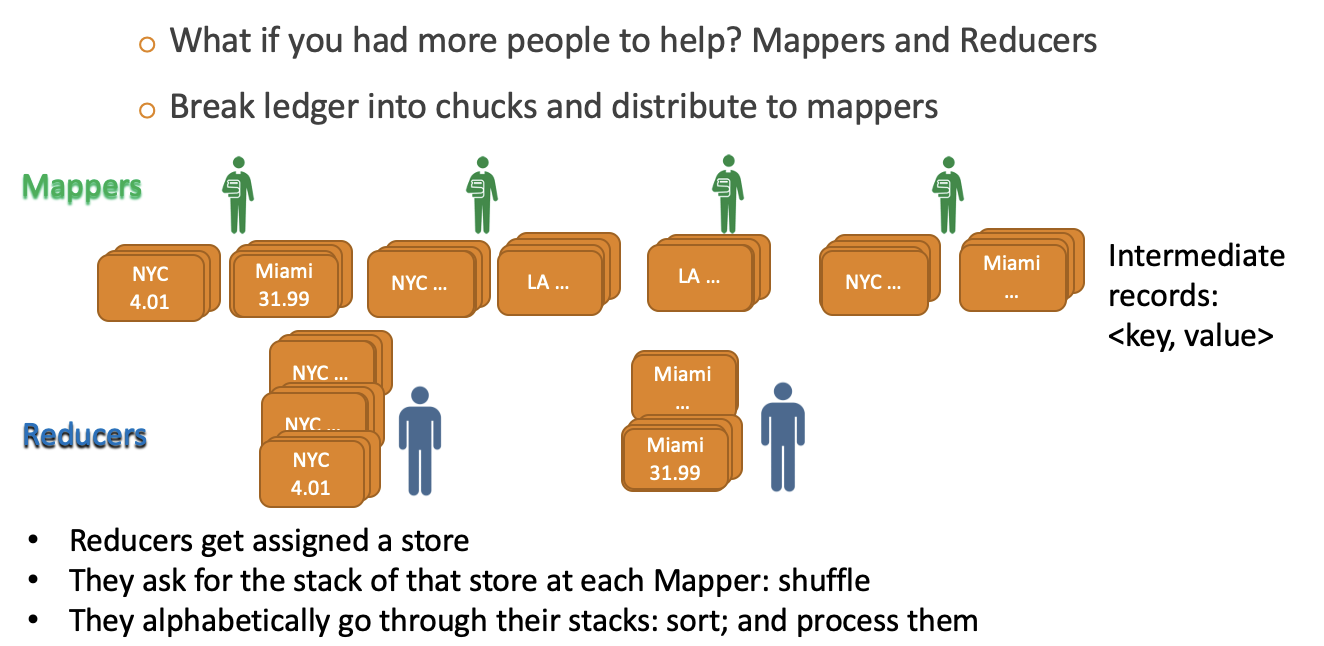



 Let's download the emulator from github: 

In [7]:
!git clone https://github.com/hideki1234/pyhdemu.git

Cloning into 'pyhdemu'...
remote: Enumerating objects: 41, done.
remote: Total 41 (delta 0), reused 0 (delta 0), pack-reused 41
Unpacking objects: 100% (41/41), done.


Run hadoop streaming emulator (hdemu.py). This demo mapper/reducers counts the occurrence of words of the files in the pyhdemu/sample/input/ folder. 

Let's first explore this folder. Remember, we can execute unix commands (just like if we were using a terminal, by starting the command with "!". 

Which files are in the folder "pyhdemu/sample/input/"? 


In [2]:
!ls pyhdemu/sample/input/

file1.txt  file2.txt


There are two text files. Let's have a look at the first few lines of file1.txt: 

In [3]:
!head pyhdemu/sample/input/file1.txt

one two three
two three four
three four five
four five six
four five six seven
five six seven
five six seven eight
six seven eight
six seven eight seven
seven eight eight


There is a demo reducer and mapper in the folder as well. Let's explore them. We can display the content of a file using the 'cat' command. 

In [4]:
!cat ./pyhdemu/sample/wc_mapper.py

#!/usr/bin/env python

from __future__ import print_function

import sys
import re

def main():
    pattern = re.compile("[A-Za-z][0-9A-Za-z]*")

    for line in sys.stdin:
        for word in pattern.findall(line):
            print('{}\t{}'.format(word.lower(), 1))

if __name__ == '__main__':
    main()


What does this mapper code do? It takes as input each line of the input files, puts the words in lower case, and outputs pairs: 

theword [tab] 1

And let's have a look at the reducer code. 

In [5]:
!cat ./pyhdemu/sample/wc_reducer.py

#!/usr/bin/env python

from __future__ import print_function

import sys

def emit(word, count):
    print('{}\t{}'.format(word, count))

def main():
    last_word = None
    last_count = 0
    for line in sys.stdin:
        word, count = line.split('\t', 1)
        try:
            count = int(count)
        except ValueError:
            continue

        if last_word == word:
            last_count += count
        else:
            if last_word:
                emit(last_word, last_count)
            last_word = word
            last_count = count

    if last_word:
        emit(last_word, last_count)


if __name__ == '__main__':
    main()


The reducer code takes an input all of the word pairs, line by line. Note that, as always in Hadoop, the reducer input is **sorted**. That allows us to just loop through the input and assume that once the word is different then the previous word, we can finalize the count of the previous word. 

The output of the reducer is a list of pairs: 

(thisword, count)

Now let's run the mapper / reducer on the input directory. This will process all the files in the input folder and save the output in the sample/output folder. 

Note, the only difference with running this on a real Hadoop cluster is that instead of the emulator `hdemu.py`, you would call `hd` (hadoop). 

In [6]:
!python ./pyhdemu/hdemu.py -input ./pyhdemu/sample/input -output ./pyhdemu/sample/output -mapper ./pyhdemu/sample/wc_mapper.py -reducer ./pyhdemu/sample/wc_reducer.py

System     : 3.7.11 (default, Jul  3 2021, 18:01:19) 
[GCC 7.5.0]
Mapper     : /content/pyhdemu/sample/wc_mapper.py
Reducer    : /content/pyhdemu/sample/wc_reducer.py
Input path : /content/pyhdemu/sample/input
Output path: /content/pyhdemu/sample/output
interim dir: None
**** mapping ****
**** shuffling ****
**** reducing ****
**** mapreduce job completed ****


If you get an error: 

`!!!! ERROR !!!! Output path '/content/pyhdemu/sample/output' already exists`

That means you have already run the command! Even if your script has an error during running, each run needs to have a unique output folder. It will save the logs and output results in that folder. So if you get this error, just change the name of your output folder. 


Now what was the result of this mapreduce task? Let's check the output folder. 

In [7]:
!ls pyhdemu/sample/output/

part-00000  _SUCCESS


The file `part-0000` will contain our output. If the output is very long, it will be split in multiple files. 

In [8]:
!cat pyhdemu/sample/output/part-00000

eight	8
finally	1
first	1
five	5
four	4
is	4
last	1
line	4
one	1
second	1
seven	7
six	6
the	4
third	1
this	4
three	3
two	2


Great! Now let's explore the example from in class... 

## Class example - counting sales per store

We will go over the first example together. We have a file: purchases.txt which contains the individual sales per store. Our goal is to get a list of total purchases per store. 


First we will download the purchases files. They are available at https://dorienherremans.com/drop/CDS/hadoop/purchases.txt.gz


In [9]:
!wget https://dorienherremans.com/drop/CDS/hadoop/purchases.txt.gz

--2021-09-15 06:34:14--  https://dorienherremans.com/drop/CDS/hadoop/purchases.txt.gz
Resolving dorienherremans.com (dorienherremans.com)... 99.198.97.250
Connecting to dorienherremans.com (dorienherremans.com)|99.198.97.250|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 38454568 (37M) [application/x-gzip]
Saving to: ‘purchases.txt.gz’

purchases.txt.gz    100%[===================>]  36.67M  79.8MB/s    in 0.5s    

2021-09-15 06:34:15 (79.8 MB/s) - ‘purchases.txt.gz’ saved [38454568/38454568]



We can create a data folder and move the uncompressed file in there: 

In [10]:
!mkdir data  # make a folder called data
!gunzip purchases.txt.gz # unzip the file
!mv purchases.txt data/ # move it into the data folder

Let's have a look at how our data file looks like. Using the `head -n` command in unix, we can show the first 10 lines of this huge file. 

In [11]:
!head -10 data/purchases.txt

2012-01-01	09:00	San Jose	Men's Clothing	214.05	Amex
2012-01-01	09:00	Fort Worth	Women's Clothing	153.57	Visa
2012-01-01	09:00	San Diego	Music	66.08	Cash
2012-01-01	09:00	Pittsburgh	Pet Supplies	493.51	Discover
2012-01-01	09:00	Omaha	Children's Clothing	235.63	MasterCard
2012-01-01	09:00	Stockton	Men's Clothing	247.18	MasterCard
2012-01-01	09:00	Austin	Cameras	379.6	Visa
2012-01-01	09:00	New York	Consumer Electronics	296.8	Cash
2012-01-01	09:00	Corpus Christi	Toys	25.38	Discover
2012-01-01	09:00	Fort Worth	Toys	213.88	Visa


Now lets create our mapper and reducer files. You can use the `Files -> upload` command on the left to upload your python files or create them directly on Colab. 

I'll start by creating a mapper and reducer file. 


In [12]:
!touch "mapper1.py"
!touch "reducer1.py"

Now you can find the file in the file menu on the left, and edit it on the right. 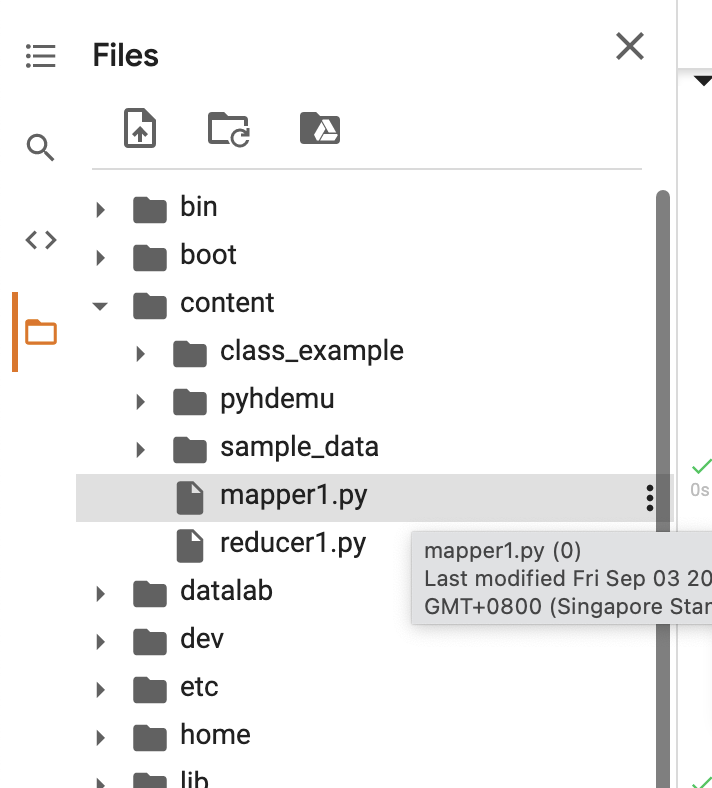

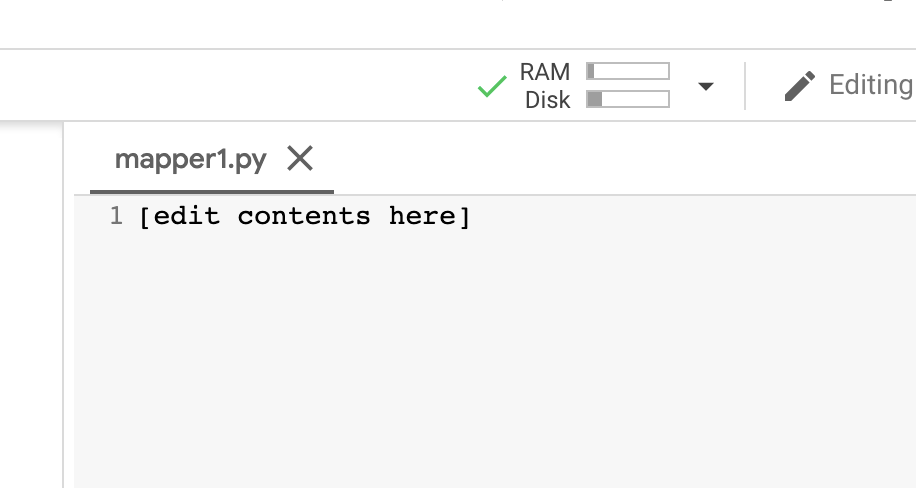

So what to put in the files? As per the class example, we are using the following. **You have to copy this into the code below into the mapper1.py and reducer1.py files**. This will return the total purchases per store. 

The mappers will go through all the input and create 'pairs' -> store with sales total of that transaction. 

`mapper1.py`

In [ ]:
#!/usr/bin/env python3

# Format of each line is:
# date\ttime\tstore name\titem description\tcost\tmethod of payment
#
# We want elements 2 (store name) and 4 (cost)
# We need to write them out to standard output, separated by a tab

import sys

for line in sys.stdin:
    data = line.strip().split("\t")
    if len(data) == 6:
        date, time, store, item, cost, payment = data
        print("{0}\t{1}".format(store, cost))


These pairs are then sorted, and fed to the reducers. These reducers loop through the pairs and output a total for each store. 

`reducer1.py`

In [ ]:
#!/usr/bin/env python3

import sys

salesTotal = 0
oldKey = None

# Loop around the data
# It will be in the format key\tval
# Where key is the store name, val is the sale amount
#
# All the sales for a particular store will be presented,
# then the key will change and we'll be dealing with the next store

for line in sys.stdin:
    data_mapped = line.strip().split("\t")
    if len(data_mapped) != 2:
        # Something has gone wrong. Skip this line.
        continue

    thisKey, thisSale = data_mapped

    if oldKey and oldKey != thisKey:
        print(oldKey, "\t", salesTotal)
        oldKey = thisKey;
        salesTotal = 0

    oldKey = thisKey
    salesTotal += float(thisSale)

if oldKey != None:
    print (oldKey, "\t", salesTotal)

3. Now you are ready to run the `hdemu.py` command. Make sure you point to the right directories.

In [13]:
!python ./pyhdemu/hdemu.py -input ./data -output output_1 -mapper mapper1.py -reducer reducer1.py

System     : 3.7.11 (default, Jul  3 2021, 18:01:19) 
[GCC 7.5.0]
Mapper     : /content/mapper1.py
Reducer    : /content/reducer1.py
Input path : /content/data
Output path: /content/output_1
interim dir: None
**** mapping ****
**** shuffling ****
**** reducing ****
**** mapreduce job completed ****


Was the output successful? Let's check the output folder.

In [14]:
!ls output_1

part-00000  _SUCCESS


The success flag is there, that's a good sign :) Now let's have a look at the output 'part-0000'

In [15]:
!head output_1/part-00000

Albuquerque 	 10052311.42000002
Anaheim 	 10076416.359999916
Anchorage 	 9933500.400000054
Arlington 	 10072207.969999947
Atlanta 	 9997146.700000068
Aurora 	 9992970.92000003
Austin 	 10057158.89999997
Bakersfield 	 10031208.919999944
Baltimore 	 10096521.450000003
Baton Rouge 	 10131273.230000038


Now this is a really long file, if we are looking for a particular city, we can use the grep command: 


In [16]:
!grep Spokane output_1/part-00000

Spokane 	 10083362.979999933


Voila. It's as easy as that. Now this gets particularly powerful when we are dealing with immense unstructured data files. Let's explore more exercises... 

## Lab exercises: 

2. Instead of breaking the sales down by store, instead retrieve a **sales breakdown by product category** across all of our stores (instead of by city). Create new mapper and reducer files for this. Hint, only 1 word needs to change. 



In [17]:
!touch mapper2.py
!touch reducer2.py

In [20]:
!python ./pyhdemu/hdemu.py -input ./data -output output_2 -mapper mapper2.py -reducer reducer2.py

System     : 3.7.11 (default, Jul  3 2021, 18:01:19) 
[GCC 7.5.0]
Mapper     : /content/mapper2.py
Reducer    : /content/reducer2.py
Input path : /content/data
Output path: /content/output_2
interim dir: None
!!!! WARNING !!!! /content/mapper2.py dosn't start with one of:
	#!/usr/bin/env python
	#!/usr/bin/env python3
!!!! WARNING !!!! /content/reducer2.py dosn't start with one of:
	#!/usr/bin/env python
	#!/usr/bin/env python3
**** mapping ****
**** shuffling ****
**** reducing ****
**** mapreduce job completed ****


In [21]:
!head output_2/part-00000

Baby 	 57491808.43999965
Books 	 57450757.91000004
CDs 	 57410753.04000111
Cameras 	 57299046.64000087
Children's Clothing 	 57624820.94000126
Computers 	 57315406.319999866
Consumer Electronics 	 57452374.12999909
Crafts 	 57418154.50000017
DVDs 	 57649212.13999929
Garden 	 57539833.109999545


In [22]:
!grep Toys output_2/part-00000

Toys 	 57463477.10999907


Even though you need to run it from files, please paste your used mapper and reducer code here for the checkoff. No need to run these cells. 

In [23]:
#mapper

#!/usr/bin/env python3

# Format of each line is:
# date\ttime\tstore name\titem description\tcost\tmethod of payment
#
# We want elements 3 (item) and 4 (cost)
# We need to write them out to standard output, separated by a tab

import sys

for line in sys.stdin:
    data = line.strip().split("\t")
    if len(data) == 6:
        date, time, store, item, cost, payment = data
        print("{0}\t{1}".format(item, cost))


In [ ]:
#reducer

#!/usr/bin/env python3

import sys

salesTotal = 0
oldKey = None

# Loop around the data
# It will be in the format key\tval
# Where key is the item name, val is the sale amount
#
# All the sales for a particular item will be presented,
# then the key will change and we'll be dealing with the next item

for line in sys.stdin:
    data_mapped = line.strip().split("\t")
    if len(data_mapped) != 2:
        # Something has gone wrong. Skip this line.
        continue

    thisKey, thisSale = data_mapped

    if oldKey and oldKey != thisKey:
        print(oldKey, "\t", salesTotal)
        oldKey = thisKey;
        salesTotal = 0

    oldKey = thisKey
    salesTotal += float(thisSale)

if oldKey != None:
    print (oldKey, "\t", salesTotal)

3. Find the monetary value for the highest individual sale for each separate store.


In [24]:
!touch mapper3.py
!touch reducer3.py

In [25]:
!python ./pyhdemu/hdemu.py -input ./data -output output_3 -mapper mapper3.py -reducer reducer3.py

System     : 3.7.11 (default, Jul  3 2021, 18:01:19) 
[GCC 7.5.0]
Mapper     : /content/mapper3.py
Reducer    : /content/reducer3.py
Input path : /content/data
Output path: /content/output_3
interim dir: None
**** mapping ****
**** shuffling ****
**** reducing ****
**** mapreduce job completed ****


In [26]:
!head output_3/part-00000

Albuquerque 	 499.98
Anaheim 	 499.98
Anchorage 	 499.99
Arlington 	 499.95
Atlanta 	 499.96
Aurora 	 499.97
Austin 	 499.97
Bakersfield 	 499.97
Baltimore 	 499.99
Baton Rouge 	 499.98


In [27]:
!grep Reno output_3/part-00000

Reno 	 499.99


Even though you need to run it from files, please paste your used mapper and reducer code here for the checkoff. No need to run these cells. 

In [ ]:
#mapper

#!/usr/bin/env python3

# Format of each line is:
# date\ttime\tstore name\titem description\tcost\tmethod of payment
#
# We want elements 2 (store name) and 4 (cost)
# We need to write them out to standard output, separated by a tab

import sys

for line in sys.stdin:
    data = line.strip().split("\t")
    if len(data) == 6:
        date, time, store, item, cost, payment = data
        print("{0}\t{1}".format(store, cost))


In [ ]:
#reducer

#!/usr/bin/env python3

import sys

currentMax = 0
oldKey = None

# Loop around the data
# It will be in the format key\tval
# Where key is the store name, val is the sale amount
#
# All the sales for a particular store will be presented,
# then the key will change and we'll be dealing with the next store

for line in sys.stdin:
    data_mapped = line.strip().split("\t")
    if len(data_mapped) != 2:
        # Something has gone wrong. Skip this line.
        continue

    thisKey, thisSale = data_mapped

    if oldKey and oldKey != thisKey:
        print(oldKey, "\t", currentMax)
        oldKey = thisKey;
        currentMax = 0

    oldKey = thisKey

    # Checking for the highest sale value for each store
    if float(thisSale) > currentMax:
      currentMax = float(thisSale)

if oldKey != None:
    print (oldKey, "\t", currentMax)

4.Find the total sales value across all the stores, and the total number of sales. Assume there is only one reducer.


In [28]:
!touch mapper4.py
!touch reducer4.py

In [32]:
!python ./pyhdemu/hdemu.py -input ./data -output output_4 -mapper mapper4.py -reducer reducer4.py

System     : 3.7.11 (default, Jul  3 2021, 18:01:19) 
[GCC 7.5.0]
Mapper     : /content/mapper4.py
Reducer    : /content/reducer4.py
Input path : /content/data
Output path: /content/output_4
interim dir: None
!!!! WARNING !!!! /content/mapper4.py dosn't start with one of:
	#!/usr/bin/env python
	#!/usr/bin/env python3
!!!! WARNING !!!! /content/reducer4.py dosn't start with one of:
	#!/usr/bin/env python
	#!/usr/bin/env python3
**** mapping ****
**** shuffling ****
**** reducing ****
**** mapreduce job completed ****


In [33]:
!head output_4/part-00000

Number of sales:  4138476 with total value 1034457953.2599705	


Even though you need to run it from files, please paste your used mapper and reducer code here for the checkoff. No need to run these cells. 

In [ ]:
#mapper
#!/usr/bin/env python3

# Format of each line is:
# date\ttime\tstore name\titem description\tcost\tmethod of payment
#
# We want elements 2 (store name) and 4 (cost)
# We need to write them out to standard output, separated by a tab

import sys

for line in sys.stdin:
    data = line.strip().split("\t")
    if len(data) == 6:
        date, time, store, item, cost, payment = data
        print("{0}\t{1}".format(store, cost))


In [ ]:
#reducer
#!/usr/bin/env python3

import sys

salesTotal = 0
numSales = 0
oldKey = None

# Loop around the data
# It will be in the format key\tval
# Where key is the store name, val is the sale amount
#
# All the sales for a particular store will be presented,
# then the key will change and we'll be dealing with the next store

for line in sys.stdin:
    data_mapped = line.strip().split("\t")
    if len(data_mapped) != 2:
        # Something has gone wrong. Skip this line.
        continue

    thisKey, thisSale = data_mapped

    oldKey = thisKey
    salesTotal += float(thisSale)
    numSales += 1

if oldKey != None:
    print ("Number of sales: ", numSales, "with total value", salesTotal)

## Answer key

You can check if you did it correctly through the following answers: 

In [ ]:
2. Total sales for Toys = 57,463,477.11
3. Highest individual sale for Reno = 499.99
4. Number of sales = 4,138,476, with total value = 1,034,457,953.26


## Advanced exercises

Common log file: use access_log as input. You can find the file here: https://dorienherremans.com/drop/CDS/hadoop/access_log.gz


`10.223.157.186 - - [15/Jul/2009:15:50:35 -0700] "GET /assets/js/lowpro.js HTTP/1.1" 200 10469 %h %l %u %t \"%r\" %>s %b `


```
%h is the IP address of the client
%l is identity of the client, or "-" if it's unavailable
%u is username of the client, or "-" if it's unavailable
%t is the time that the server finished processing the request. The format is [day/month/year:hour:minute:second zone]
%r is the request line from the client is given (in double quotes). It contains the method, path, query-string, and protocol or the request.
%>s is the status code that the server sends back to the client. You will see see mostly status codes 200 (OK - The request has succeeded), 304 (Not Modified) and 404 (Not Found). See more information on status codes in W3C.org
%b is the size of the object returned to the client, in bytes. It will be "-" in case of status code 304.
You'll have to write new Mappers and Reducers
```




5. Write a MapReduce program to find number of hits for each different file on the Web site.



In [1]:
!wget https://dorienherremans.com/drop/CDS/hadoop/access_log.gz

--2021-09-15 08:56:09--  https://dorienherremans.com/drop/CDS/hadoop/access_log.gz
Resolving dorienherremans.com (dorienherremans.com)... 99.198.97.250
Connecting to dorienherremans.com (dorienherremans.com)|99.198.97.250|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 54547198 (52M) [application/x-gzip]
Saving to: ‘access_log.gz’

access_log.gz       100%[===================>]  52.02M  43.5MB/s    in 1.2s    

2021-09-15 08:56:10 (43.5 MB/s) - ‘access_log.gz’ saved [54547198/54547198]



In [2]:
!mkdir data2
!gunzip access_log.gz # unzip the file
!mv access_log data2/ # move it into the data2 folder

In [3]:
!head data2/access_log

10.223.157.186 - - [15/Jul/2009:14:58:59 -0700] "GET / HTTP/1.1" 403 202
10.223.157.186 - - [15/Jul/2009:14:58:59 -0700] "GET /favicon.ico HTTP/1.1" 404 209
10.223.157.186 - - [15/Jul/2009:15:50:35 -0700] "GET / HTTP/1.1" 200 9157
10.223.157.186 - - [15/Jul/2009:15:50:35 -0700] "GET /assets/js/lowpro.js HTTP/1.1" 200 10469
10.223.157.186 - - [15/Jul/2009:15:50:35 -0700] "GET /assets/css/reset.css HTTP/1.1" 200 1014
10.223.157.186 - - [15/Jul/2009:15:50:35 -0700] "GET /assets/css/960.css HTTP/1.1" 200 6206
10.223.157.186 - - [15/Jul/2009:15:50:35 -0700] "GET /assets/css/the-associates.css HTTP/1.1" 200 15779
10.223.157.186 - - [15/Jul/2009:15:50:35 -0700] "GET /assets/js/the-associates.js HTTP/1.1" 200 4492
10.223.157.186 - - [15/Jul/2009:15:50:35 -0700] "GET /assets/js/lightbox.js HTTP/1.1" 200 25960
10.223.157.186 - - [15/Jul/2009:15:50:36 -0700] "GET /assets/img/search-button.gif HTTP/1.1" 200 168


In [4]:
!touch mapper5.py
!touch reducer5.py

In [8]:
!python ./pyhdemu/hdemu.py -input ./data2 -output output_5 -mapper mapper5.py -reducer reducer5.py

System     : 3.7.11 (default, Jul  3 2021, 18:01:19) 
[GCC 7.5.0]
Mapper     : /content/mapper5.py
Reducer    : /content/reducer5.py
Input path : /content/data2
Output path: /content/output_5
interim dir: None
!!!! WARNING !!!! /content/mapper5.py dosn't start with one of:
	#!/usr/bin/env python
	#!/usr/bin/env python3
!!!! WARNING !!!! /content/reducer5.py dosn't start with one of:
	#!/usr/bin/env python
	#!/usr/bin/env python3
**** mapping ****
**** shuffling ****
**** reducing ****
**** mapreduce job completed ****


In [9]:
!head output_5/part-00000 

/	
99303	
/#TB_inline?inlineId=vidplay0&width=480&height=286&background=#000000	
2	
/#TB_inline?inlineId=vidplay0&width=480&height=300&background=#000000	
6	
/#TB_inline?inlineId=vidplay0&width=480&height=390&background=#000000	
6	
/#TB_inline?inlineId=vidplay1&width=480&height=300&background=#000000	
13	


In [ ]:
#mapper 

#!/usr/bin/env python3

# We want the path element

import sys

for line in sys.stdin:
    data = line.strip().split(" ")
    if len(data) == 10:
        ip, identity, username, time, zone, method, path, protocol, status, size = data
        print("{0}".format(path))


In [ ]:
#reducer
#!/usr/bin/env python3

import sys

hitsTotal = 0
oldKey = None

# Loop around the data
# We increment the number of hits, looping through each path.

for line in sys.stdin:
    thisKey = line

    if oldKey and oldKey != thisKey:
        print(oldKey, "\t", hitsTotal)
        oldKey = thisKey;
        hitsTotal = 0

    oldKey = thisKey
    hitsTotal += 1

if oldKey != None:
    print (oldKey, "\t", hitsTotal)

6. Write a MapReduce program which determines the number of hits to the site made by each different IP address.


In [ ]:
!touch mapper6.py
!touch reducer6.py

In [ ]:
!python ./pyhdemu/hdemu.py -input ./data2 -output output_6 -mapper mapper6.py -reducer reducer6.py

System     : 3.7.11 (default, Jul  3 2021, 18:01:19) 
[GCC 7.5.0]
Mapper     : /content/mapper6.py
Reducer    : /content/reducer6.py
Input path : /content/data2
Output path: /content/output_6
interim dir: None
**** mapping ****
**** shuffling ****
**** reducing ****
**** mapreduce job completed ****


In [ ]:
!head output_6/part-00000 

10.1.1.113	
1	
10.1.1.125	
12	
10.1.1.144	
1	
10.1.1.195	
4	
10.1.1.236	
12	


In [ ]:
#mapper
#!/usr/bin/env python3

# We want the ip element

import sys

for line in sys.stdin:
    data = line.strip().split(" ")
    if len(data) == 10:
        ip, identity, username, time, zone, method, path, protocol, status, size = data
        print("{0}".format(ip))


In [ ]:
#reducer
#!/usr/bin/env python3

import sys

hitsTotal = 0
oldKey = None

# Loop around the data
# We increment the number of hits, looping through each ip.

for line in sys.stdin:
    thisKey = line

    if oldKey and oldKey != thisKey:
        print(oldKey, "\t", hitsTotal)
        oldKey = thisKey;
        hitsTotal = 0

    oldKey = thisKey
    hitsTotal += 1

if oldKey != None:
    print (oldKey, "\t", hitsTotal)

7. Find the most popular file on the website, i.e. whose file path occurs most often in access_log. Your reducer should output the file’s path and number of times it appears in the log


In [ ]:
!touch mapper7.py
!touch reducer7.py

In [ ]:
!python ./pyhdemu/hdemu.py -input ./data2 -output output_7 -mapper mapper7.py -reducer reducer7.py

System     : 3.7.11 (default, Jul  3 2021, 18:01:19) 
[GCC 7.5.0]
Mapper     : /content/mapper7.py
Reducer    : /content/reducer7.py
Input path : /content/data2
Output path: /content/output_7
interim dir: None
**** mapping ****
**** shuffling ****
**** reducing ****
**** mapreduce job completed ****


In [ ]:
!cat output_7/part-00000 

/assets/css/combined.css	
117348	


In [ ]:
#!/usr/bin/env python3

# Format of each line is:
# date\ttime\tstore name\titem description\tcost\tmethod of payment
#
# We want the path element

import sys

for line in sys.stdin:
    data = line.strip().split(" ")
    if len(data) == 10:
        ip, identity, username, time, zone, method, path, protocol, status, size = data
        print("{0}".format(path))


In [ ]:
#!/usr/bin/env python3

import sys

hitsTotal = 0
oldKey = None

topHits = 0

# Loop around the data
# Each line will increment hitsTotal for the respective path. Once the path has been incremented all the way, it checks if it is higher than the current topHits record
# and updates the topHits and currentTop if it is.

for line in sys.stdin:
    thisKey = line

    if oldKey and oldKey != thisKey:
        if hitsTotal > topHits:
          topHits = hitsTotal
          currentTop = oldKey
        oldKey = thisKey;
        hitsTotal = 0

    oldKey = thisKey
    hitsTotal += 1

if oldKey != None:
    print (currentTop, "\t", topHits)